## Libs


In [81]:
%load_ext autoreload
%autoreload 2
from typing import Optional, Tuple, Literal

import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jrandom 
import jax.nn as jnn
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial

jax.config.update('jax_enable_x64', True)
# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
from lib.ml.icnn_modules import ProbStackedICNNImputer, ImputerMetrics, ProbICNNImputerTrainer
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config, append_params_to_zip, zip_members
 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading

### First Time Loading

In [2]:
# tvx = m4aki.TVxAKIMIMICIVDataset.load('/home/asem/GP/ehr-data/mimic4aki-cohort/tvx_aki.h5')

In [3]:
# obs = [adm.observables  for subject in tvx0.subjects.values() for adm in subject.admissions]
# adm_id = sum(([adm.admission_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])
# subj_id = sum(([subject.subject_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])

In [4]:
# obs_val = np.vstack([obs_i.value for obs_i in obs])
# obs_mask = np.vstack([obs_i.mask for obs_i in obs])
# obs_time = np.hstack([obs_i.time for obs_i in obs])

In [5]:
# tvx0.scheme.obs
# features = list(map(tvx0.scheme.obs.desc.get, tvx0.scheme.obs.codes))

In [6]:
# obs_val = pd.DataFrame(obs_val, columns=features)
# obs_mask = pd.DataFrame(obs_mask.astype(int), columns=features)
# meta = pd.DataFrame({'subject_id': subj_id, 'admission_id': adm_id, 'time': obs_time})


In [7]:
# artificial_mask = obs_mask.copy()
# artificial_mask = obs_mask & np.array(jrandom.bernoulli(jrandom.PRNGKey(0), p=0.8, shape=obs_mask.shape))


In [8]:
# obs_val.to_csv('missingness_data/missingness_vals.csv')
# obs_mask.to_csv('missingness_data/missingness_mask.csv')
# meta.to_csv('missingness_data/meta.csv')
# artificial_mask.to_csv('missingness_data/missingness_artificial_mask.csv')


### Later Loading

In [9]:
obs_val = pd.read_csv('missingness_data/missingness_vals.csv', index_col=[0])
obs_mask = pd.read_csv('missingness_data/missingness_mask.csv', index_col=[0])
artificial_mask = pd.read_csv('missingness_data/missingness_artificial_mask.csv', index_col=[0])
meta = pd.read_csv('missingness_data/meta.csv', index_col=[0])


,blood_chemistry.albumin,blood_chemistry.aniongap,blood_chemistry.bicarbonate,blood_chemistry.bun,blood_chemistry.calcium,blood_chemistry.chloride,blood_chemistry.creatinine,blood_chemistry.globulin,blood_chemistry.glucose,blood_chemistry.potassium,...,vital.glucose,vital.heart_rate,vital.mbp,vital.mbp_ni,vital.resp_rate,vital.sbp,vital.sbp_ni,vital.spo2,vital.temperature,weight.weight
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.4224
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0502,0.0672,0.0000,0.0,0.0,0.0,0.0,0.0000
693894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0119,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000
693895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.2815,0.0000,0.0000,0.6943,0.0,0.0,0.0,0.0,0.0000
693896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0255,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000


### Split

In [10]:
split_ratio = 0.7
seed = 0
indices = jrandom.permutation(jrandom.PRNGKey(seed), len(obs_val))
train_idx = indices[:int(split_ratio * len(indices))]
test_idx = indices[int(split_ratio * len(indices)):]

obs_val_train = jnp.array(obs_val.iloc[train_idx].to_numpy())
obs_mask_train = jnp.array(obs_mask.iloc[train_idx].to_numpy())
art_mask_train =  jnp.array(artificial_mask.iloc[train_idx].to_numpy())

obs_val_test = jnp.array(obs_val.iloc[test_idx].to_numpy())
obs_mask_test = jnp.array(obs_mask.iloc[test_idx].to_numpy())
art_mask_test =  jnp.array(artificial_mask.iloc[test_idx].to_numpy())

2024-07-12 11:39:40.171691: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Model Configuration

In [11]:
# model = ICNNObsDecoder(observables_size=obs_mask.shape[1], state_size=0, 
#                        optax_optimiser_name='polyak_sgd',
#                        hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))

model = ProbStackedICNNImputer(observables_size=obs_mask.shape[1],
                               state_size = 0,
                               optax_optimiser_name='polyak_sgd',
                               hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))
trainer = ProbICNNImputerTrainer(loss='log_normal')

## Training

In [12]:
lr=1e-3
steps=10000
train_batch_size=256
test_batch_size=1024
# train_batch_size=1
# test_batch_size=1
eval_frequency = 10
model_snapshot_frequency = 100

optim = optax.novograd(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
data_train = (obs_val_train, obs_mask_train, art_mask_train)
data_test = (obs_val_test, obs_mask_test, art_mask_test)

In [13]:
train_batches = trainer.dataloader(data_train, train_batch_size, key=jrandom.PRNGKey(0))
test_batches = iter(trainer.dataloader(data_test, train_batch_size, key=jrandom.PRNGKey(0)))
train_history = defaultdict(list)
test_history = defaultdict(list)
model_snapshots = {}

In [14]:
progress = tqdm(range(steps))

for step, batch_train in zip(progress, train_batches):
    start = time.time()
    (train_loss, train_aux), model, opt_state = trainer.make_step(model, optim, opt_state, *batch_train)
    r2_vec =  trainer.model_r_squared(model, *batch_train)
    r2_vec_rank = trainer.model_r_squared_ranked_prob(model, *batch_train, k=5)
    r2_vec = np.array(r2_vec)
    train_nsteps = int(sum(train_aux.n_steps) / len(train_aux.n_steps))
    train_history['R2'].append(r2_vec)
    train_history['R2_rank5'].append(r2_vec_rank)
    train_history['loss'].append(train_loss)
    train_history['n_opt_steps'].append(train_nsteps)
    
    end = time.time()
    if (step % eval_frequency) == 0 or step == steps - 1:
        batch_test = next(test_batches)
        test_loss, _ = trainer.loss(model, *batch_test)
        r2_vec_test = trainer.model_r_squared(model, *batch_test)
        r2_vec_rank_test = trainer.model_r_squared_ranked_prob(model, *batch_test, k=10)
        r2_vec_test = np.array(r2_vec_test)
        test_history['loss'].append(test_loss)
        test_history['R2'].append(r2_vec_test)
        test_history['R2_rank10'].append(r2_vec_rank_test)

    if (step % model_snapshot_frequency) == 0 or step == steps - 1:
        model_snapshots[step] = model

    progress.set_description(f"Trn-L: {train_loss:.3f}, Trn-R2: ({np.nanmax(r2_vec_rank):.2f}, {np.nanmin(r2_vec_rank):.2f}, {np.nanmean(r2_vec_rank):.2f}, {np.nanmedian(r2_vec_rank):.2f}),  Trn-N-steps: {train_nsteps}, " 
                             f"Tst-L:  {test_loss:.3f}, Tst-R2:  ({np.nanmax(r2_vec_rank_test):.2f}, {np.nanmin(r2_vec_rank_test):.2f}, {np.nanmean(r2_vec_rank_test):.2f}, {np.nanmedian(r2_vec_rank_test):.2f}), "
                             f"Computation time: {end - start:.2f}, ")
                            

  0%|          | 0/10000 [00:00<?, ?it/s]

In [74]:
model_snapshots.keys()

dict_keys([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 9999])

In [15]:
print('x')

x


In [24]:
train_stats = pd.DataFrame(train_history)
test_stats = pd.DataFrame(test_history)

In [18]:
train_stats

,R2,R2_rank5,loss,n_opt_steps
0,"[nan, -31.01952179968974, -3.623016560420341, ...","[nan, nan, -3.623016560420341, nan, -1.5884292...",2.3016409498610373,1024
1,"[nan, -29.184131109736327, nan, nan, -90.70617...","[nan, nan, nan, nan, nan, -29.443878974672284,...",2.3018408857775947,1024
2,"[-inf, -6.458156855239868, -6.7827012640893, -...","[nan, -5.35361122549977, -12.43889684746066, -...",2.301339954649288,1024
3,"[nan, -16.37756351237662, -5.747049157840063, ...","[nan, -13.499071855870476, -4.615941229195867,...",2.3013221870631533,1024
4,"[nan, -4.579379700997328, -6.773255351092956, ...","[nan, -4.133232520826985, nan, nan, -8.1069257...",2.301314045173178,1024
...,...,...,...,...
9995,"[-1.9295977309435526, -0.2556355951983653, -1....","[nan, -0.2556355951983651, -1.2178013230066598...",-1.2266723282690173,1024
9996,"[nan, -0.00626220897996177, -1.579817885012246...","[nan, -0.7797176584827237, nan, -0.35608041288...",-1.4233158326711113,1024
9997,"[nan, -0.8963422310544771, -4.331402856055318,...","[nan, 0.22323550821221028, -4.331402856055317,...",-1.3000076119874575,1024
9998,"[nan, -1.9572835530666781, -0.3593748478513199...","[nan, nan, -0.08402923307686705, nan, -1.88403...",-1.3552890100628838,1024


In [77]:
dataframes = []
for step, model_snap in tqdm(model_snapshots.items()):
    with jax.default_device(jax.devices("cpu")[0]):
        obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
        (X_test_imp, X_test_std), _ = eqx.filter_vmap(model_snap.prob_partial_input_optimise)(obs_test, art_mask_test)
    
    sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
    predicted_mask = (1 - art_mask_test) * obs_mask_test
    r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, predicted_mask.T, X_test_std.T,  t)
                          for t in sigma_threshold]
    
    r2_test_results = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
    r2_test_results['sigma_threshold'] = sigma_threshold
    r2_test_results['step'] = step
    dataframes.append(r2_test_results)

r2_test_results = pd.concat(dataframes)
r2_test_results = pd.melt(r2_test_results, value_vars=list(obs_val.columns), id_vars=['sigma_threshold'], value_name='R2')

  0%|          | 0/101 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
with jax.default_device(jax.devices("cpu")[0]):
    obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
    (X_test_imp, X_test_std), _ = eqx.filter_vmap(model.prob_partial_input_optimise)(obs_test, art_mask_test)

Array([-1.87915558e+01, -6.33369034e-01, -5.11465155e-01, -2.19971067e-01,
       -2.20461971e+00, -2.34748836e+00, -4.59303248e-01, -2.51282567e+02,
       -9.04534840e-01, -1.57817533e+00, -6.74661491e+00, -1.35193962e+03,
       -4.07137586e+00, -1.70193146e+00, -2.28732732e+00, -1.43623806e+01,
       -1.66726030e+00, -3.41289945e+00, -1.48219329e+00, -1.96682856e+00,
       -2.88947338e+01, -2.33359374e+00, -1.66584282e+00, -4.21020320e+00,
       -2.49924272e+00, -2.21743253e+00, -1.85146469e+01, -6.62758135e-01,
       -1.54838129e-02, -2.88188724e-02, -4.88063699e+01, -1.77136074e+01,
       -9.16572390e-02, -1.59472977e+01, -4.09815441e-01, -7.18194864e-02,
       -9.10330404e+00, -8.80125776e-01, -5.06712765e-01, -1.66565185e+00,
                  -inf, -3.45942789e-01, -8.53762935e-01, -3.69930724e+01,
       -2.54899606e-01, -1.65676358e+00, -2.65332057e+01, -3.81384078e+01,
       -7.17007525e+01, -1.05380614e+00, -6.37962087e+00, -2.23021044e+00,
       -4.43867940e+02, -

In [118]:
prediction_mask = (1 - art_mask_test) * obs_mask_test
SE = (X_test_imp - obs_val_test) ** 2
SE = jnp.where(prediction_mask, SE, jnp.nan)
X_test_var = jnp.where(prediction_mask, X_test_std ** 2, jnp.nan)
se_data = defaultdict(list)
for i in range(SE.shape[1]):
    se_data['SE'].extend(np.array(SE[:, i][prediction_mask[:, i].astype(bool)]).tolist())
    se_data['sigma2'].extend(np.array(X_test_var[:, i][prediction_mask[:, i].astype(bool)]).tolist())
    se_data['Feature'].extend([obs_val.columns[i]] * int(prediction_mask[:, i].sum()))
    



    

In [114]:
SE[:, 0][prediction_mask[:, 0].astype(bool)].shape

(612,)

In [119]:
se_df = pd.DataFrame(se_data)

In [120]:
se_df

,SE,sigma2,Feature
0,0.698059,4.595124,blood_chemistry.albumin
1,0.687116,1.099257,blood_chemistry.albumin
2,0.000719,2.270627,blood_chemistry.albumin
3,0.000834,2.123337,blood_chemistry.albumin
4,0.201607,1.423159,blood_chemistry.albumin
...,...,...,...
362999,0.000418,0.019524,weight.weight
363000,0.041595,0.016579,weight.weight
363001,0.008200,0.016579,weight.weight
363002,0.039207,0.026999,weight.weight


In [155]:
feature2index =  dict(zip(obs_val.columns, range(len(obs_val.columns))))
n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)
n_test = ((1 - art_mask_test) * obs_mask_test).sum(axis=0)
n_train_measured = obs_mask_train.sum(axis=0)
missingness = 1 - obs_mask.mean(axis=0)
r2 = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, X_test_imp.T, predicted_mask.T)


In [165]:
from scipy.stats import spearmanr

se_df[['SE', 'sigma2']].corr(method='spearman')
feature_sigma_corr = defaultdict(list)
n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)

for feature, feature_df in se_df.groupby('Feature'):
    feature_sigma_corr['Feature'].append(feature)
    feature_sigma_corr['n_training_measured'].append(n_train_measured[feature2index[feature]])
    feature_sigma_corr['n_training_censored'].append(n_train[feature2index[feature]])
    feature_sigma_corr['n_test_censored'].append(n_test[feature2index[feature]])
    feature_sigma_corr['missingness'].append(missingness[feature2index[feature]].item())
    feature_sigma_corr['R2'].append(r2[feature2index[feature]].item())

    feature_sigma_corr['sigma2_se_spearman'].append(spearmanr(feature_df['SE'], feature_df['sigma2']).statistic)
    

/tmp/ipykernel_1108528/2984184186.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  feature_sigma_corr['missingness'].append(missingness[feature2index[feature]].item())


In [166]:
feature_corrs_df = pd.DataFrame(feature_sigma_corr)
feature_corrs_df.to_csv('experiment_snapshots_mimic_ProbStackedICNN_lognormal/features_stats.csv')

In [164]:
feature_sigma_corr.sort_values(by='missingness')

,Feature,n_training_measured,n_training_censored,n_test_censored,missingness,R2,sigma2_se_spearman
91,vital.heart_rate,256149,51113,22041,0.472492,-0.062090,0.002877
94,vital.resp_rate,256055,51434,21899,0.472667,-0.029139,-0.007356
95,vital.sbp,251900,50184,21660,0.481493,0.167349,-0.045933
92,vital.mbp,250778,50208,21455,0.483897,0.159933,0.035420
88,vital.dbp,250547,49912,21812,0.484286,0.086894,-0.042985
...,...,...,...,...,...,...,...
30,blood_gas.bicarbonate,73,13,4,0.999860,-48.806370,0.800000
40,blood_gas.methemoglobin,38,10,2,0.999924,-inf,1.000000
32,blood_gas.carboxyhemoglobin,34,8,4,0.999929,-0.091657,0.200000
67,coagulation.thrombin,29,7,3,0.999942,-78.802156,0.500000


In [131]:
spearmanr(se_data['SE'], se_data['sigma2'])

SignificanceResult(statistic=0.5286208633600269, pvalue=0.0)

In [49]:
r2_test_results = r2_test_results[r2_test_results.R2 >= 0]

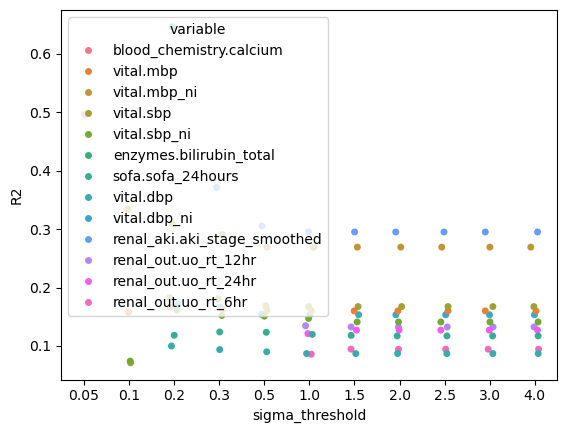

In [50]:
import seaborn as sns
r2_test_results 
g = sns.stripplot(data=r2_test_results, x="sigma_threshold", y="R2", hue="variable")
# g.set_ylim(bottom=0, top=1.0);


In [67]:
train_stats['split'] = 'Train'
train_stats['iteration'] = train_stats.index + 1
test_stats['split'] = 'Test'
test_stats['iteration'] = (test_stats.index * eval_frequency) + 1


In [68]:
stats = pd.concat([train_stats, test_stats])

In [69]:
stats

,R2,R2_rank5,loss,n_opt_steps,split,iteration,R2_rank10
0,"[nan, -31.01952179968974, -3.623016560420341, ...","[nan, nan, -3.623016560420341, nan, -1.5884292...",2.3016409498610373,1024.0,Train,1,NaN
1,"[nan, -29.184131109736327, nan, nan, -90.70617...","[nan, nan, nan, nan, nan, -29.443878974672284,...",2.3018408857775947,1024.0,Train,2,NaN
2,"[-inf, -6.458156855239868, -6.7827012640893, -...","[nan, -5.35361122549977, -12.43889684746066, -...",2.301339954649288,1024.0,Train,3,NaN
3,"[nan, -16.37756351237662, -5.747049157840063, ...","[nan, -13.499071855870476, -4.615941229195867,...",2.3013221870631533,1024.0,Train,4,NaN
4,"[nan, -4.579379700997328, -6.773255351092956, ...","[nan, -4.133232520826985, nan, nan, -8.1069257...",2.301314045173178,1024.0,Train,5,NaN
...,...,...,...,...,...,...,...
996,"[nan, -3.264853724711637, -5.7629628682274046,...",NaN,-1.2629441696579744,NaN,Test,9961,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
997,"[nan, -1.9941235853966903, -0.4474038417167387...",NaN,-1.365583532211642,NaN,Test,9971,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
998,"[-1.9879555962956585, -2.0052848294333567, 0.4...",NaN,-1.3803303033759833,NaN,Test,9981,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
999,"[nan, -4.655576050225162, -7.82580842596073, -...",NaN,-1.1727268949265939,NaN,Test,9991,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [70]:
stats_melted = pd.melt(stats, value_vars=['loss'], id_vars=['split', 'iteration'], value_name='Loss')

In [71]:
stats_melted = stats_melted.astype({'Loss': float})

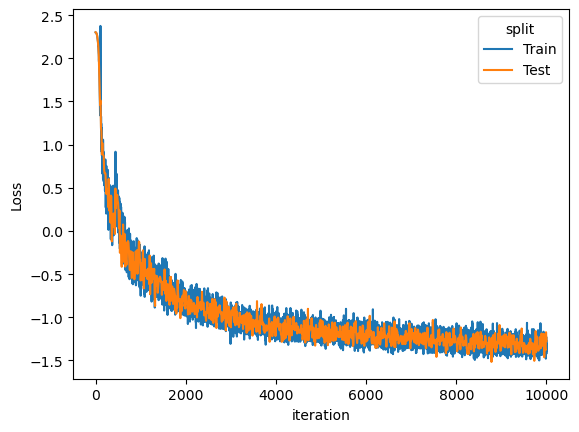

In [72]:
g2 = sns.lineplot(data=stats_melted, x="iteration", y="Loss", hue="split")


In [66]:
stats_melted[stats_melted.split == 'Train']

,split,iteration,variable,Loss
0,Train,1,loss,2.301641
1,Train,2,loss,2.301841
2,Train,3,loss,2.301340
3,Train,4,loss,2.301322
4,Train,5,loss,2.301314
...,...,...,...,...
9995,Train,9996,loss,-1.226672
9996,Train,9997,loss,-1.423316
9997,Train,9998,loss,-1.300008
9998,Train,9999,loss,-1.355289


In [79]:
for step, m_snapshot in model_snapshots.items():
    append_params_to_zip(m_snapshot, f'step{step:04d}.eqx', 'experiment_snapshots_mimic_ProbStackedICNN_lognormal/params.zip')

In [82]:
zip_members('experiment_snapshots_mimic_ProbStackedICNN_lognormal/params.zip')

['step0000.eqx',
 'step0100.eqx',
 'step0200.eqx',
 'step0300.eqx',
 'step0400.eqx',
 'step0500.eqx',
 'step0600.eqx',
 'step0700.eqx',
 'step0800.eqx',
 'step0900.eqx',
 'step1000.eqx',
 'step1100.eqx',
 'step1200.eqx',
 'step1300.eqx',
 'step1400.eqx',
 'step1500.eqx',
 'step1600.eqx',
 'step1700.eqx',
 'step1800.eqx',
 'step1900.eqx',
 'step2000.eqx',
 'step2100.eqx',
 'step2200.eqx',
 'step2300.eqx',
 'step2400.eqx',
 'step2500.eqx',
 'step2600.eqx',
 'step2700.eqx',
 'step2800.eqx',
 'step2900.eqx',
 'step3000.eqx',
 'step3100.eqx',
 'step3200.eqx',
 'step3300.eqx',
 'step3400.eqx',
 'step3500.eqx',
 'step3600.eqx',
 'step3700.eqx',
 'step3800.eqx',
 'step3900.eqx',
 'step4000.eqx',
 'step4100.eqx',
 'step4200.eqx',
 'step4300.eqx',
 'step4400.eqx',
 'step4500.eqx',
 'step4600.eqx',
 'step4700.eqx',
 'step4800.eqx',
 'step4900.eqx',
 'step5000.eqx',
 'step5100.eqx',
 'step5200.eqx',
 'step5300.eqx',
 'step5400.eqx',
 'step5500.eqx',
 'step5600.eqx',
 'step5700.eqx',
 'step5800.eqx

In [83]:
mxxx = ProbStackedICNNImputer(observables_size=obs_mask.shape[1],
                               state_size = 0,
                               optax_optimiser_name='polyak_sgd',
                               hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))
mxxx = mxxx.load_params_from_archive( 'experiment_snapshots_mimic_ProbStackedICNN_lognormal/params.zip',  'step8800.eqx')

In [84]:
mxxx 

ProbStackedICNNImputer(
  f_energy=ICNN(
    Wzs=(
      Linear(
        weight=f64[400,200],
        bias=f64[400],
        in_features=200,
        out_features=400,
        use_bias=True
      ),
      PositiveAbsLinear(
        weight=f64[400,400],
        bias=f64[400],
        in_features=400,
        out_features=400,
        use_bias=True
      ),
      PositiveAbsLinear(
        weight=f64[400,400],
        bias=f64[400],
        in_features=400,
        out_features=400,
        use_bias=True
      ),
      PositiveAbsLinear(
        weight=f64[400,400],
        bias=f64[400],
        in_features=400,
        out_features=400,
        use_bias=True
      ),
      PositiveAbsLinear(
        weight=f64[1,400],
        bias=f64[1],
        in_features=400,
        out_features=1,
        use_bias=True
      )
    ),
    Wxs=(
      Linear(
        weight=f64[400,200],
        bias=f64[400],
        in_features=200,
        out_features=400,
        use_bias=True
      ),
      L

In [167]:
print('x')

x
